In [1]:
import pandas as pd
import numpy as np
import helper_functions as hf
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
import importlib
importlib.reload(hf)
import math
import copy


In [682]:


f = open("../data/AG_new/feces/otu_train_ibd_250.obj", "rb")
otu_train = pickle.load(f)
f.close()

f = open("../data/AG_new/feces/otu_test_ibd_250.obj", "rb")
otu_test = pickle.load(f)
f.close()

f = open("../data/AG_new/feces/qual_vecs_ibd_250.obj", "rb")
qual_vecs = pickle.load(f)
f.close()

f = open("../data/AG_new/feces/map_train_ibd_250.obj", "rb")
map_train = pickle.load(f)
f.close()

f = open("../data/AG_new/feces/map_test_ibd_250.obj", "rb")
map_test = pickle.load(f)
f.close()

In [2]:
number_criteria = ["BMI", "AGE_CORRECTED"]
cat_criteria = ["IBD", "EXERCISE_FREQUENCY", "SEX", "ONE_LITER_OF_WATER_A_DAY_FREQUENCY", 
        "SEAFOOD_FREQUENCY", "PROBIOTIC_FREQUENCY", "OLIVE_OIL", "FRUIT_FREQUENCY", 
         "SLEEP_DURATION", "SUGAR_SWEETENED_DRINK_FREQUENCY", "MILK_CHEESE_FREQUENCY",
         "RED_MEAT_FREQUENCY","MEAT_EGGS_FREQUENCY", "VEGETABLE_FREQUENCY", "BODY_SITE"]

otu_file = "../data/AG_new/feces/otu_filtered_AG_07perc_feces.csv"
mapping_file = "../data/AG_new/AG_mapping.txt"
qual_vec_file = "../data/AG_new/feces/glove_emb_AG_new07perc_feces_250.txt"
test_samples_file = "../data/AG_new/feces/AG_test_samples_feces.obj"
otu_train, otu_test, qual_vecs, map_train, map_test = hf.getDataAG(otu_file, mapping_file, qual_vec_file, test_samples_file,
                                                                   number_criteria, cat_criteria)
qual_vecs.columns = ['topic_' + str(i) for i in range(1, qual_vecs.shape[1]+1)]

Original data dimensions
Taxa: 9162  Samples: 15475
Filter for taxa present in embeddings
Taxa: 7731  Samples: 15475


c:\users\ctata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0,81) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\scripts\helper_functions.py:65: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  map_clean = mapping.loc[otu_clean.columns.values] #Keep samples if present in otu


Samples originally: 15475
Samples after categorical filter: 6567
Samples after numerical filter: 6300
Filter for desired metadata present
Samples: 6300  Taxa: 7731
(5419, 7731)
(5419, 17)
(881, 7731)
(881, 17)


In [25]:
qual_vecs.columns

Index(['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'topic_10',
       ...
       'topic_241', 'topic_242', 'topic_243', 'topic_244', 'topic_245',
       'topic_246', 'topic_247', 'topic_248', 'topic_249', 'topic_250'],
      dtype='object', length=250)

In [3]:
importlib.reload(hf)
map_train, map_test = hf.makeMappingNumeric(map_train, map_test, number_criteria, cat_criteria)

BMI
AGE_CORRECTED
EXERCISE_FREQUENCY
ONE_LITER_OF_WATER_A_DAY_FREQUENCY
SEAFOOD_FREQUENCY
PROBIOTIC_FREQUENCY
OLIVE_OIL
FRUIT_FREQUENCY
SUGAR_SWEETENED_DRINK_FREQUENCY
MILK_CHEESE_FREQUENCY
RED_MEAT_FREQUENCY
MEAT_EGGS_FREQUENCY
VEGETABLE_FREQUENCY
SLEEP_DURATION
SEX
IBD


In [4]:
map_train = map_train.drop('BODY_SITE', axis = 1)
map_test = map_test.drop('BODY_SITE', axis = 1)

In [5]:
#Both of these functions need to take in non-normalized data

#Embed weighted by the number of times an organisms appears
taxa_occurrence = otu_train > 1
taxa_present = taxa_occurrence.sum(axis = 0) #total number of occurrences (0,1) of each taxa
taxa_present = taxa_present + 1

def embed_occurrence(otu, qual_vecs):
    taxa = [i for i in otu_use.columns.values if i in qual_vecs.index.values]
    qual_vecs_use = qual_vecs.loc[taxa]
    occurrence = np.matrix(otu > 1)
    taxa_present_use = np.array(taxa_present[otu_use.columns.values])
    inverse_freq_mat = pd.DataFrame(occurrence / taxa_present_use)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu_use.index.values)
    return(df)

#Embed weighted by the inverse of the overall normalized abundance of that organism in ALL samples
otu_tmp = hf.asinh(otu_train)
taxa_abundance = otu_tmp.sum(axis = 0) #total abundance of each taxa summed over samples

def embed_abundance(otu, qual_vecs):
    taxa = [i for i in otu.columns.values if i in qual_vecs.index.values]
    qual_vecs_use = qual_vecs.loc[taxa]
    otu_use = otu.loc[:, taxa]
    abundance = np.matrix(hf.asinh(otu_use))
    overall_taxa_abundance = np.array(taxa_abundance[otu_use.columns.values])
    inverse_freq_mat = pd.DataFrame(abundance / overall_taxa_abundance)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu_use.index.values)
    return(df)

def embed_average(otu, qual_vecs):
    taxa = [i for i in otu.columns.values if i in qual_vecs.index.values]
    qual_vecs_use = qual_vecs.loc[taxa]
    otu_use = otu.loc[:, taxa]
    df = pd.DataFrame(np.dot(hf.asinh(otu_use), qual_vecs_use), index = otu.index.values)
    return(df)

In [6]:
pathway_table = pd.read_table("C:/Users/ctata/Documents/Lab/quality_vectors/interpretation/allbodysites/pathways/pathway_table.txt")

153

In [101]:
map_train_save = copy.deepcopy(map_train)
map_test_save = copy.deepcopy(map_test)

pathway_dict = pd.read_table("C:/Users/ctata/Documents/Lab/quality_vectors/interpretation/allbodysites/pathways/topic_pathway_dict.txt")
pathway_dict = pathway_dict.set_index("topic")
pathway_dict.loc[X_test.columns.values[0], "pathway_names"]

#Create input for ML alg including otu abundances and metadata
def combineData(microbe_data, mapping_data, naming = "topics"):
    micro_norm = preprocessing.scale(microbe_data)
    map_norm = preprocessing.scale(mapping_data)
    data = pd.concat([pd.DataFrame(micro_norm), pd.DataFrame(map_norm)], axis = 1)
    if naming == "topics":
        data.columns = ['topic_' + str(i) for i in range(1, microbe_data.shape[1] +1)] + [i for i in mapping_data.columns.values]
    elif naming == "pathways":
        topics = ['topic_' + str(i) for i in range(1, microbe_data.shape[1] +1)]
        data.columns = list(pathway_dict.loc[topics, "pathway_names"]) + [i for i in mapping_data.columns.values]
    return(data)

def setTarget(mapping, target = ""):
    y = [float(i) for i in mapping[target]]
    mapping = mapping.drop(target, axis = 1)
    return(mapping, y)

def getMlInput(otu_train, otu_test, map_train, map_test, target, 
               embed = False, pca_reduced = False, asinNormalized = False, percNormalized = False, pathwayEmbed = False,
               qual_vecs = None, numComponents = 250, naming = "topics"):
    
    #split training set again to get some validation data for training hyperparameters
    otu_train_train = otu_train.sample(frac = 0.9, random_state = 10)
    otu_val = otu_train.drop(otu_train_train.index.values)
    map_train_train = map_train.loc[otu_train_train.index.values]
    map_val = map_train.drop(otu_train_train.index.values)
    
    map_train_train, y_train = setTarget(map_train_train, target = target)
    map_val, y_val = setTarget(map_val, target = target)
    map_test, y_test = setTarget(map_test, target = target)
    
    if embed:
        X_train = combineData(embed_average(otu_train_train, qual_vecs), map_train_train, naming = naming)
        X_val = combineData(embed_average(otu_val, qual_vecs), map_val, naming = naming)
        X_test = combineData(embed_average(otu_test, qual_vecs), map_test, naming = naming)
    elif pca_reduced:
        pca_train, pca_val, pca_test = hf.getPCAReduced(otu_train_train, otu_val, otu_test, components = numComponents)
        X_train = combineData(pca_train, map_train_train, naming = naming)
        X_val = combineData(pca_val, map_val, naming = naming)
        X_test = combineData(pca_test, map_test, naming = naming)
    elif asinNormalized:
        X_train = combineData(hf.asinh(otu_train_train), map_train_train, naming = naming)
        X_val = combineData(hf.asinh(otu_val), map_val, naming = naming)
        X_test = combineData(hf.asinh(otu_test), map_test, naming = naming)
    elif percNormalized: 
        X_train = combineData(otu_train_train.div(otu_train_train.sum(axis=1), axis=0), map_train_train, naming = naming)
        X_val = combineData(otu_val.div(otu_val.sum(axis=1), axis=0), map_val, naming = naming)
        X_test = combineData(otu_test.div(otu_test.sum(axis=1), axis=0), map_test, naming = naming)
    elif pathwayEmbed:
        X_train = combineData(embed_average(otu_train_train, pathway_table), map_train_train, naming = naming)
        X_val = combineData(embed_average(otu_val, pathway_table), map_val, naming = naming)
        X_test = combineData(embed_average(otu_test, pathway_table), map_test, naming = naming)
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

#6% of patients have IBD

In [102]:
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs, naming = "pathways")
print(X_train.columns.values)

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


['Flagellar assembly' 'Phosphotransferase system (PTS)'
 'Aminobenzoate degradation' 'beta-Alanine metabolism'
 'Fatty acid degradation' 'Secondary bile acid biosynthesis'
 'Carbapenem biosynthesis' 'Geraniol degradation'
 'NOD-like receptor signaling pathway' 'Steroid biosynthesis'
 'Tetracycline biosynthesis' 'Lipoic acid metabolism'
 'Geraniol degradation' 'Other glycan degradation'
 'Staphylococcus aureus infection'
 'Biosynthesis of unsaturated fatty acids' 'Cyanoamino acid metabolism'
 'Synthesis and degradation of ketone bodies'
 'Porphyrin and chlorophyll metabolism' 'Streptomycin biosynthesis'
 'Peptidoglycan biosynthesis' 'Secondary bile acid biosynthesis'
 'Neomycin, kanamycin and gentamicin biosynthesis'
 'Sphingolipid metabolism' 'Sesquiterpenoid and triterpenoid biosynthesis'
 'Xylene degradation' 'Phosphotransferase system (PTS)'
 'Styrene degradation' 'Sphingolipid metabolism'
 'Lipopolysaccharide biosynthesis'
 'Neomycin, kanamycin and gentamicin biosynthesis'
 'Synthe

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
importlib.reload(hf)

def trainHyperParameters(X_train, y_train, X_val, y_val):
    depths = [2, 3, 5, 10]
    n_estimators = [50, 65, 80, 95, 110, 125, 140, 155]
    aucs = np.zeros((len(depths), len(n_estimators)))
    aucs_train = np.zeros((len(depths), len(n_estimators)))
    for depth in depths:
        for trees in n_estimators:
            print(depth, trees)
            auc, auc_train = hf.predictIBD(X_train, y_train, X_val, y_val, "Embedding weighted by averaging taxa",
                                     max_depth = depth, n_estimators = trees)
            aucs[depths.index(depth), n_estimators.index(trees)] = np.mean(auc)
            aucs_train[depths.index(depth), n_estimators.index(trees)] = np.mean(auc_train)
            print(np.mean(auc_train), np.mean(auc))
            
    plt.figure(figsize=(15,5))
    for i in range(aucs.shape[0]):
        plt.subplot(2,3, i + 1)
        plt.plot(n_estimators, aucs[i,:])
        plt.plot(n_estimators, aucs_train[i, :])
        plt.title("Depth: " + str(depths[i]))
        plt.xticks(n_estimators)


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs)
trainHyperParameters(X_train, y_train, X_val, y_val)
#Ideal is depth of 2 and trees of 95

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


2 50
0.8199344541978187 0.7544291338582677
2 65
0.8301426412671797 0.7242647058823528
2 80
0.837304018491186 0.7517079666512274
2 95
0.8356094938814635 0.7636926817971283
2 110
0.8391987934413159 0.7762274201018989
2 125
0.8444239898808539 0.7693955534969893
2 140
0.8463975458432207 0.772406206577119
2 155
0.8487056462901105 0.7699455766558592
3 50
0.87883590244932 0.7196908290875406
3 65
0.8807343416325771 0.6978635942566003
3 80
0.8808955678901785 0.7226146364057434
3 95
0.8840116317416393 0.7291280685502548
3 110
0.8864377204952284 0.7415759610930986
3 125
0.890938498045498 0.742820750347383
3 140
0.8916248089102425 0.7425023158869848
3 155
0.8882947538441469 0.7473077813802687
5 50
0.9490059668372245 0.7232225567392311
5 65
0.9508347855910628 0.726175312644743
5 80
0.9559511543067198 0.7354678091709124
5 95
0.9601485333540484 0.7409101435849931
5 110
0.9602969347957043 0.7465551181102362
5 125
0.9618491039484312 0.7496815655396016
5 140
0.9628062016412833 0.7376679018063919
5 155
0

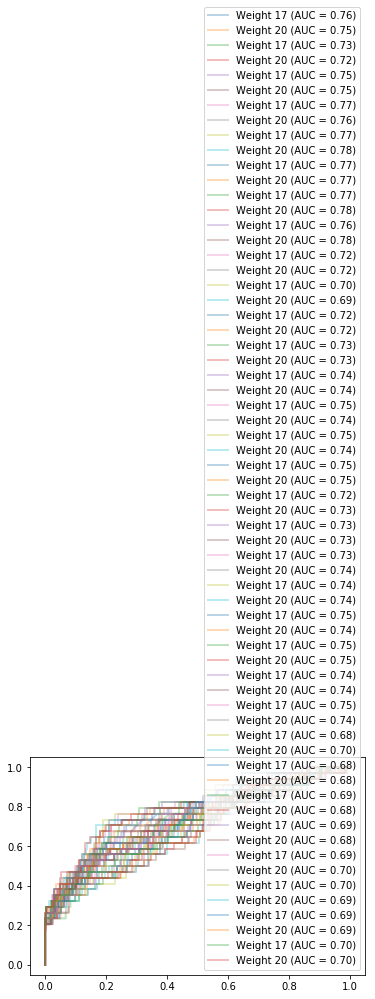

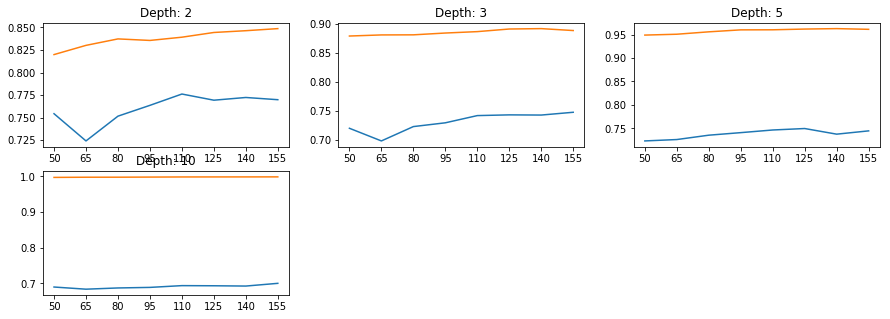

In [817]:
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = False)
trainHyperParameters(X_train, y_train, X_val, y_val)
#Ideal is depth of 2 and trees of 110

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


2 50
0.7933687640248523 0.7683534043538676
2 65
0.7985485239736116 0.7607109773043076
2 80
0.8011274112486095 0.7755326540064845
2 95
0.7995492260406789 0.7696271421954608
2 110
0.8042346809405647 0.7661243631310792
2 125
0.8050726910567796 0.7634321445113479
2 140
0.8094796642389901 0.7623320981936081
2 155
0.8084357242210207 0.7568318666049096
3 50
0.8885611435925022 0.7943492357572951
3 65
0.9012782310841292 0.7969835572024085
3 80
0.9060094888981065 0.8023969430291802
3 95
0.9099661278289711 0.8042786012042612
3 110
0.9129088734535105 0.7996468272348309
3 125
0.9139865244162511 0.7884726725335804
3 140
0.9175818699607634 0.7956808707735064
3 155
0.916930735734041 0.7988941639647984
5 50
0.9889596655874279 0.719922417786012
5 65
0.9920266287149828 0.7213119499768412
5 80
0.9923644710093202 0.7118457619268179
5 95
0.9928045454079097 0.7105430754979156
5 110
0.9925788286472678 0.716622278832793
5 125
0.9928968840827178 0.707561371005095
5 140
0.9928657381011357 0.7249305233904586
5 15

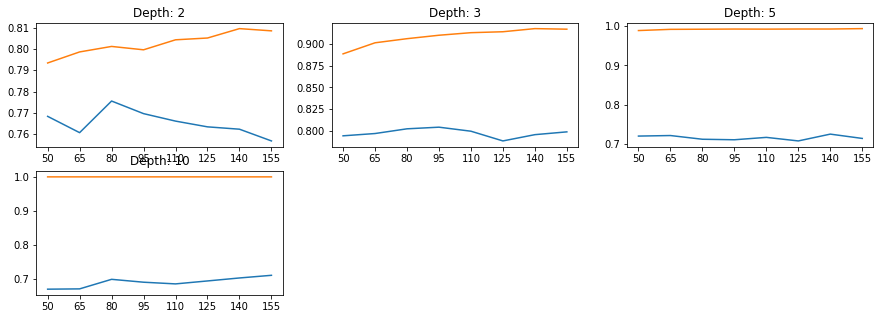

In [851]:
importlib.reload(hf)
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", pca_reduced = True, numComponents = 250)
trainHyperParameters(X_train, y_train, X_val, y_val)

#Ideal depth of 2 with 80 trees

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\users\ctata\minicon

2 50
0.7597053809996321 0.6702871699861047
2 65
0.7629990135884421 0.6765053265400649
2 80
0.763279473992006 0.6770148216767021
2 95
0.7668680773475642 0.6867762853172765
2 110
0.7687661501075086 0.6851435849930523
2 125
0.7697104962690778 0.6865910143584993
2 140
0.770155920448033 0.683487725798981
2 155
0.7725671324151253 0.6848772579898101
3 50
0.8061858117961925 0.7403774895785087
3 65
0.8048285798458383 0.7433534043538674
3 80
0.809045672467392 0.7403195924038907
3 95
0.8096143614487497 0.75032422417786
3 110
0.8102364016644412 0.7459935155164427
3 125
0.8120151669937605 0.7464451134784622
3 140
0.8127005251578918 0.744129226493747
3 155
0.8136461904433869 0.7448355720240851
5 50
0.8956882235944368 0.7395553496989347
5 65
0.8983944796129396 0.7420912459471978
5 80
0.9020103448629649 0.737610004631774
5 95
0.9015045341220717 0.7382005558128762
5 110
0.8991733490064797 0.7432607688744788
5 125
0.8992334424297678 0.7437239462714219
5 140
0.9010264249836208 0.7450555812876332
5 155
0.

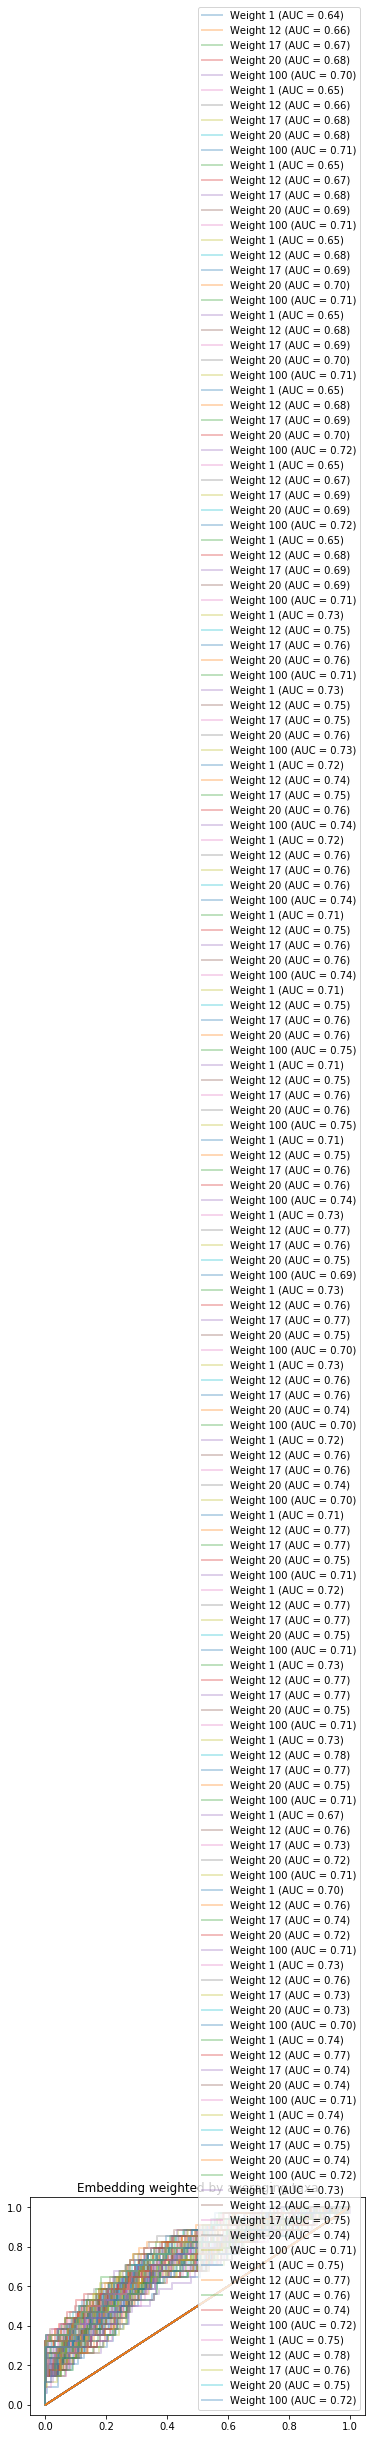

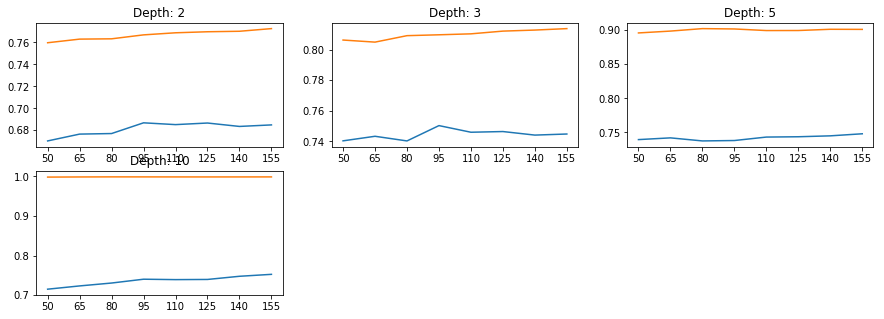

In [90]:
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", pathwayEmbed = True)
trainHyperParameters(X_train, y_train, X_val, y_val)

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3

([0.6396341463414634,
  0.6620751699320272,
  0.6892443022790884,
  0.6606357457017193],
 [0.7252395664829556,
  0.7591125263783658,
  0.802408572761658,
  0.8437545148157007])

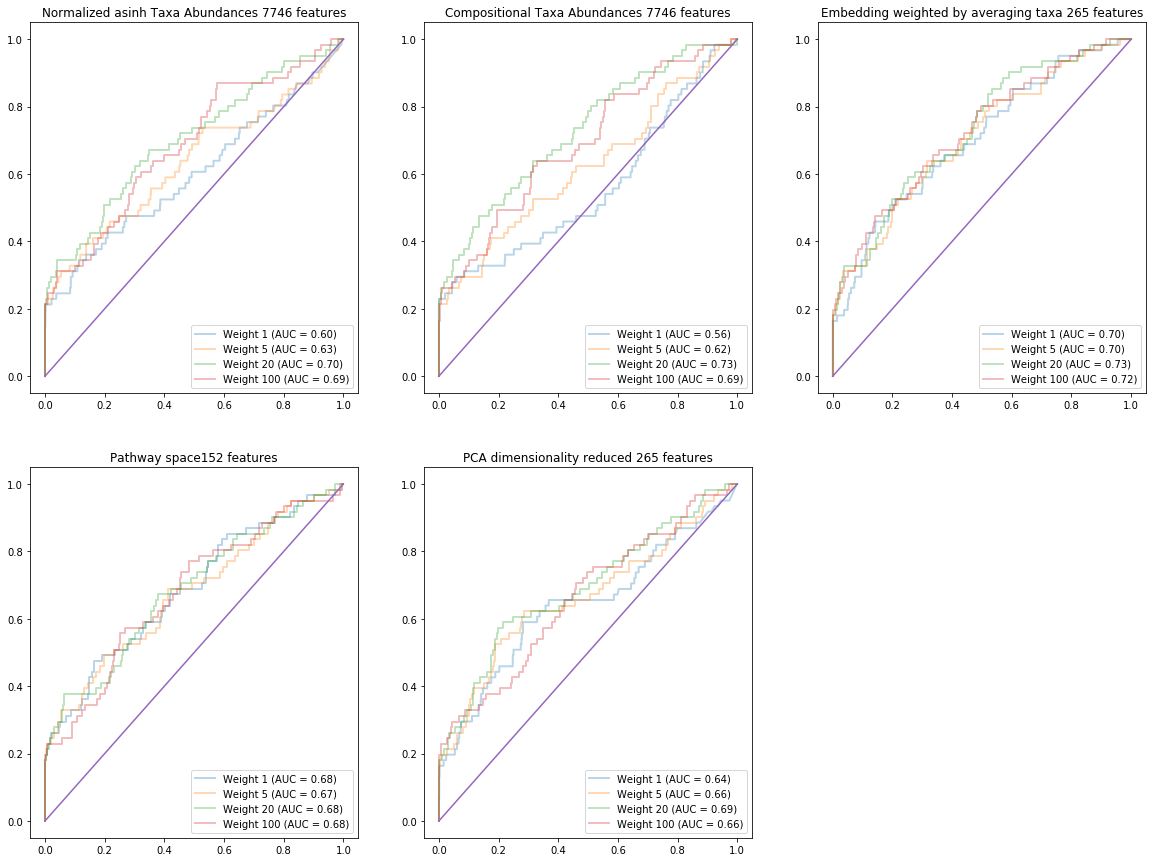

In [95]:
importlib.reload(hf)
plt.figure(figsize=(20,15))
i = 2
j = 3
plt.subplot(i,j, 1)

#Normalize with asinh
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", asinNormalized = True)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Normalized asinh Taxa Abundances " + str(X_train.shape[1]) + " features",
              max_depth = 2, n_estimators = 110, plot = True)


plt.subplot(i, j, 2)

#Normalize by percent
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", percNormalized = True)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Compositional Taxa Abundances " + str(X_train.shape[1]) + " features",
              max_depth = 2, n_estimators = 110, plot = True)


plt.subplot(i, j, 3)
#Embed Average
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Embedding weighted by averaging taxa "+ str(X_train.shape[1]) + " features",
              max_depth = 2, n_estimators = 95, plot = True)


plt.subplot(i, j, 4)
#Embed Average
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", pathwayEmbed = True, qual_vecs = pathway_table)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Pathway space"+ str(X_train.shape[1]) + " features",
              max_depth = 3, n_estimators = 95, plot = True)


plt.subplot(i, j, 5)
#PCA
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", pca_reduced = True, numComponents = 250)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "PCA dimensionality reduced " + str(X_train.shape[1]) + " features", 
              max_depth = 2, n_estimators = 80, plot = True)


#They all perform a bit worse with a prior weight of 1 on IBD, but embeddings retain their ability to predict
#accurately much more than the others. Again, this means MEANINGFUL BIOLOGICAL INFORMATION is being encoded. Most consistent
#w.r.t choices of hyperparameters (eg. weight of IBD)

Here we start playing with increasing sparsity of the taxa membership in a topic and the number of topics used to predict

In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier


#Embed using sparse quality vector 
#qual_vecs_reduced = copy.deepcopy(qual_vecs_taxReduced)
#qual_vecs_reduced[np.abs(qual_vecs_taxReduced) < .3 ] = 0

X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs)

def reducedFeatures(table, feat_imp_sort, numFeatures = 20):
    selected_features = [x[0] for x in feat_imp_sort[0:numFeatures]]
    table_limited = table.loc[:, selected_features]
    return(table_limited, selected_features)

def getReducedFeatureData(X_train, X_val, X_test, y_train, y_val, y_test, max_depth = 2, n_estimators = 95, numFeatures = 50):
    weight = 20
    weights = {0:1, 1:weight}
    m = RandomForestClassifier(max_depth= max_depth, random_state=0, n_estimators= n_estimators, class_weight = weights)
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_val)

    feat_imp = m.feature_importances_
    feat_imp_labeled = zip(X_test.columns.values, feat_imp)
    feat_imp_sort = sorted(feat_imp_labeled, key = lambda t: t[1], reverse = True)
    
    
    X_train, selected_features = reducedFeatures(X_train, feat_imp_sort, numFeatures = numFeatures)
    X_val, selected_features = reducedFeatures(X_val, feat_imp_sort, numFeatures = numFeatures)
    X_test, selected_fetures = reducedFeatures(X_test, feat_imp_sort, numFeatures = numFeatures)
    
    return(X_train, X_val, X_test, y_train, y_val, y_test, feat_imp_sort)

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


In [104]:
#We want to be able to interpret using only the important topics

X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs,  naming = "pathways")
X_train, X_val, X_test, y_train, y_val, y_test, feat_imp = getReducedFeatureData(X_train, X_val, X_test, y_train, y_val, y_test,
                                                                                 max_depth = 3, n_estimators = 95, numFeatures = 250)


c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


In [105]:
feat_imp

[('2-Oxocarboxylic acid metabolism', 0.06429544412625218),
 ('PROBIOTIC_FREQUENCY', 0.05804104024696788),
 ('Geraniol degradation', 0.040565657219033775),
 ('Phosphotransferase system (PTS)', 0.04001419024715071),
 ('Polycyclic aromatic hydrocarbon degradation', 0.03947817552961466),
 ('Selenocompound metabolism', 0.022457717972429354),
 ('Secondary bile acid biosynthesis', 0.021797746096486926),
 ('Cyanoamino acid metabolism', 0.020120443540090616),
 ('Chloroalkane and chloroalkene degradation', 0.01859491469625375),
 ('Limonene and pinene degradation', 0.018327029703827807),
 ('Phosphotransferase system (PTS)', 0.01684965267680242),
 ('Mannose type O-glycan biosynthesis', 0.015773061610172712),
 ('Phosphotransferase system (PTS)', 0.01556084512139542),
 ('Bacterial invasion of epithelial cells', 0.01435681983249039),
 ('Xylene degradation', 0.01326506938917637),
 ('Xylene degradation', 0.013057576812683627),
 ('Secondary bile acid biosynthesis', 0.012171996005856538),
 ('Lipopolysacc

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all co

([0.6926329468212715,
  0.7033486605357857,
  0.7059976009596162,
  0.7039984006397442,
  0.697171131547381],
 [0.7541912292377688,
  0.7922116024546387,
  0.8035454181577892,
  0.8081531946539845,
  0.8262228193292138])

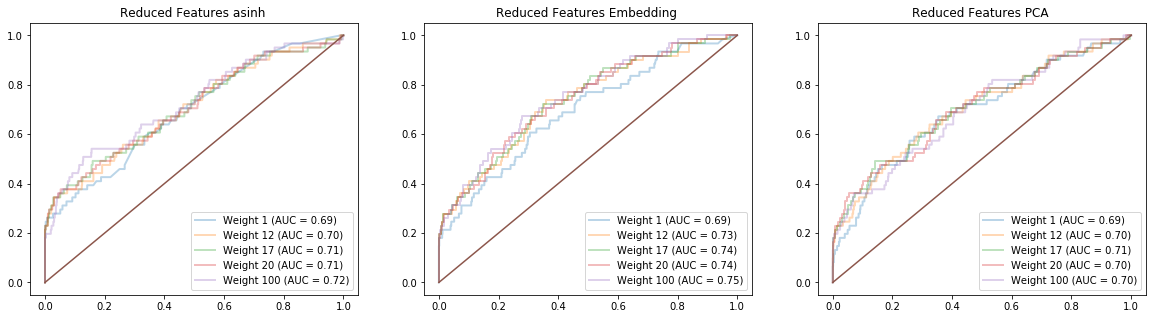

In [994]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", asinNormalized = True)
X_train, X_val, X_test, y_train, y_val, y_test, _ = getReducedFeatureData(X_train, X_val, X_test, y_train, y_val, y_test, max_depth = 2, n_estimators = 95)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Reduced Features asinh " + str(X_train.shape[1]) + " features",
              max_depth = 2, n_estimators = 110, plot = True)

###############################
plt.subplot(1, 3, 2)
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs)
X_train, X_val, X_test, y_train, y_val, y_test, _ = getReducedFeatureData(X_train, X_val, X_test, y_train, y_val, y_test, max_depth = 2, n_estimators = 95)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Reduced Features Embedding " + str(X_train.shape[1]) + " features",
              max_depth = 2, n_estimators = 95, plot = True)

###################################
plt.subplot(1, 3, 3)
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", pca_reduced = True, numComponents = 250)
X_train, X_val, X_test, y_train, y_val, y_test, _ = getReducedFeatureData(X_train, X_val, X_test, y_train, y_val, y_test, max_depth = 2, n_estimators = 95)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val
hf.predictIBD(X_train, y_train, X_test, y_test, graphTitle = "Reduced Features PCA " + str(X_train.shape[1]) + " features",
              max_depth = 2, n_estimators = 80, plot = True)

## Explore each decision tree to understand the directionality of each variable

In [106]:
#Great, now we have a minimal model that makes ok predictions - time to try to interpret it
X_train, X_val, X_test, y_train, y_val, y_test = getMlInput(otu_train, otu_test, map_train, map_test, 
                                                            target = "IBD", embed = True, qual_vecs = qual_vecs,
                                                           naming = "pathways")
X_train, X_val, X_test, y_train, y_val, y_test, _ = getReducedFeatureData(X_train, X_val, X_test, y_train, y_val, y_test, 
                                                                          max_depth = 2, n_estimators = 95, numFeatures = 250)
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = y_train + y_val

max_depth = 2
n_estimators = 95
weight = 20
weights = {0:1, 1:weight}
m = RandomForestClassifier(max_depth= max_depth, random_state=0, n_estimators=n_estimators, class_weight = weights)
m.fit(X_train, y_train)

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=95, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [22]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def makeDecisionTreeImage(est):
    dot_data = StringIO()
    export_graphviz(est, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names =  X_test.columns.values, class_names=  ["NO IBD", "IBD"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('diabetes.png')
    return(Image(graph.create_png()))



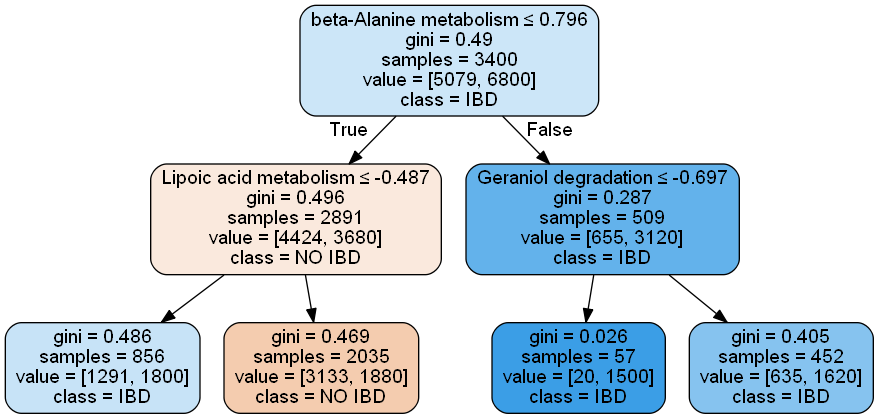

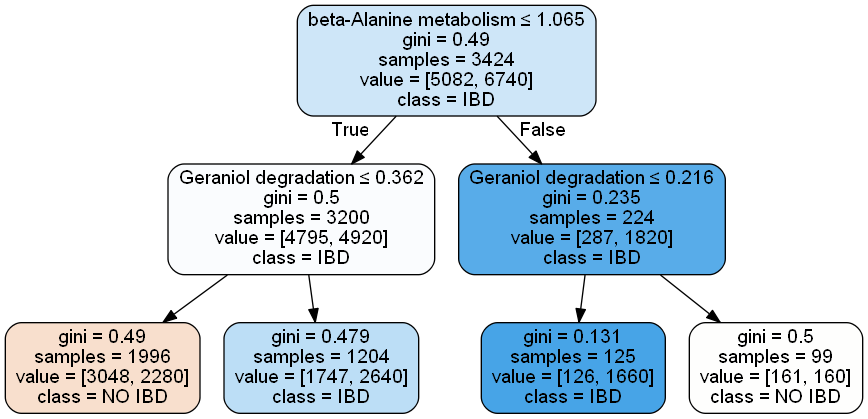

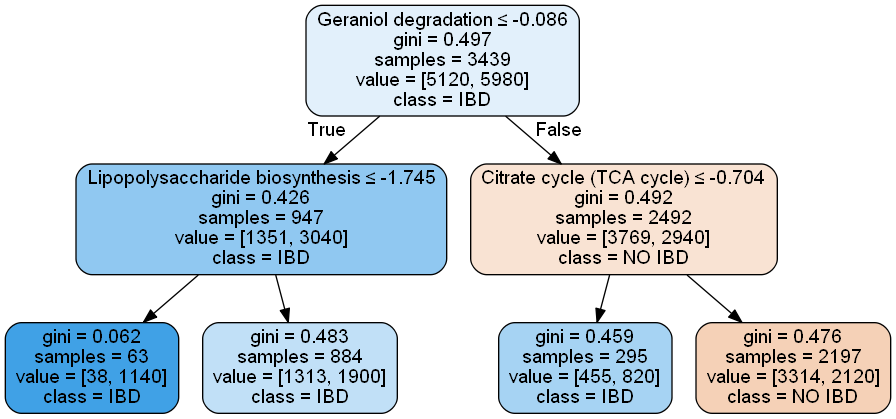

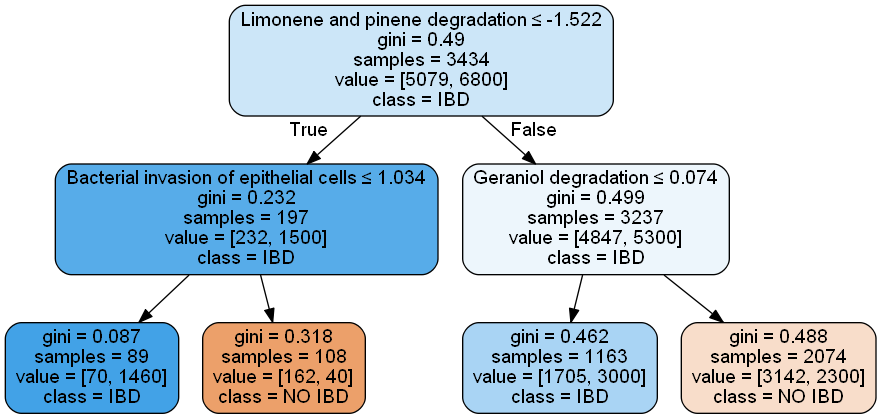

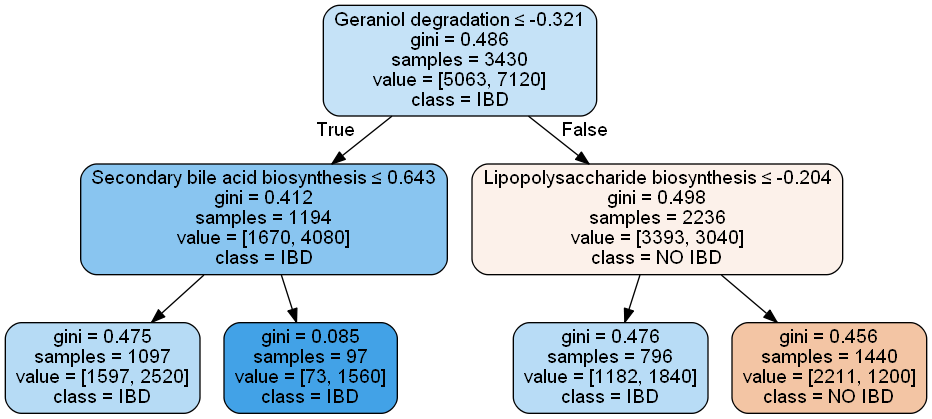

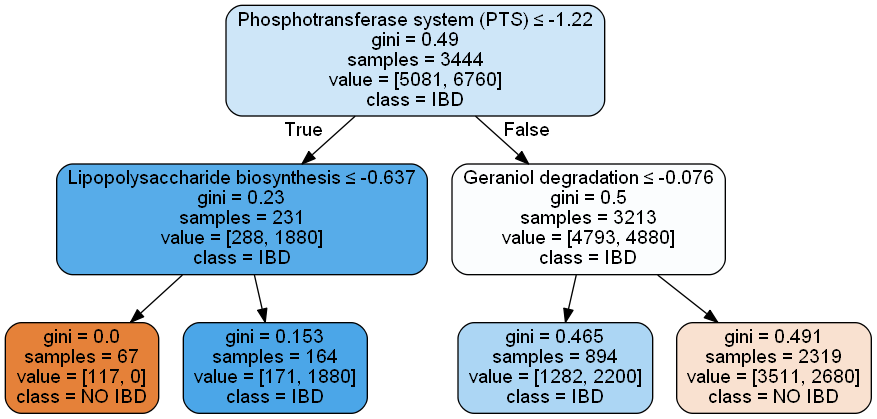

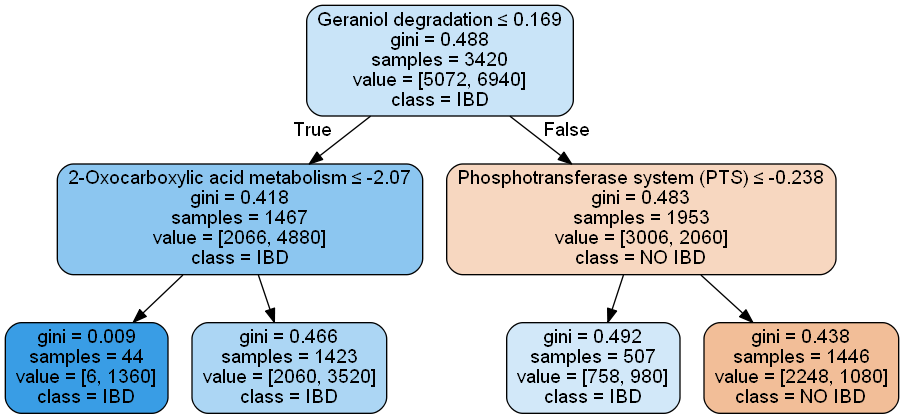

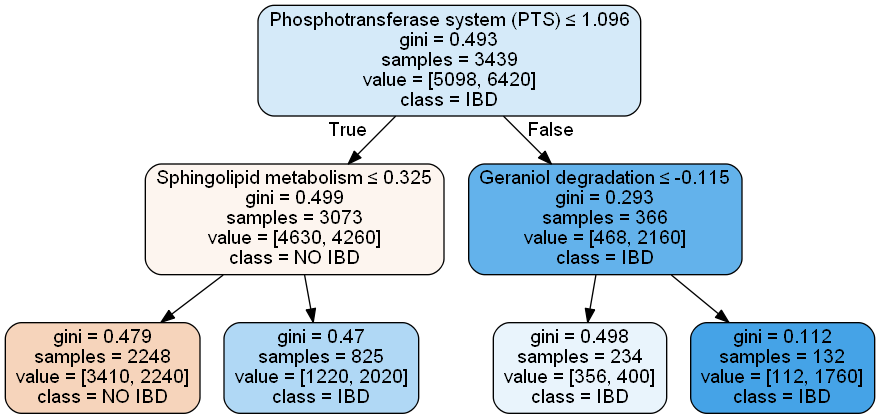

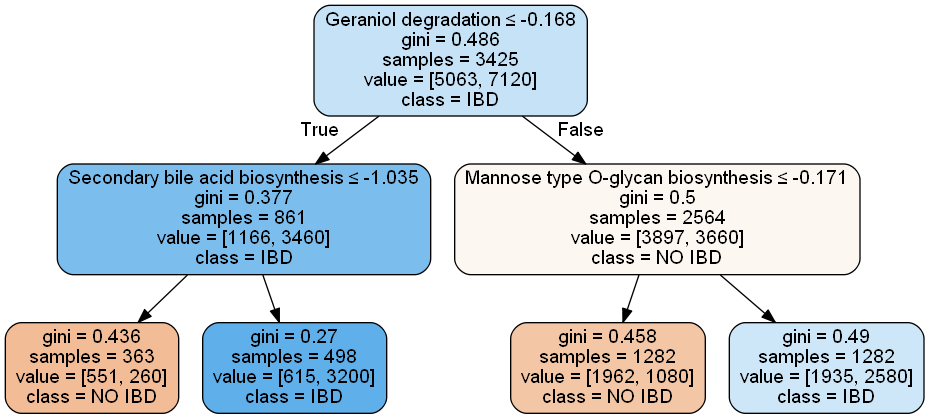

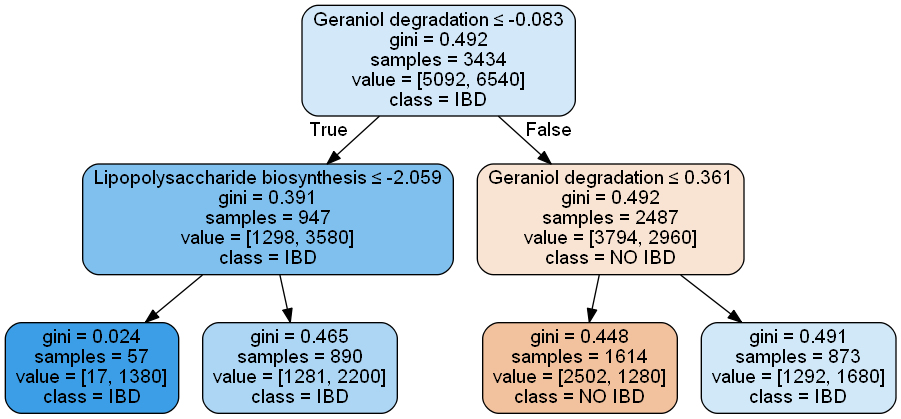

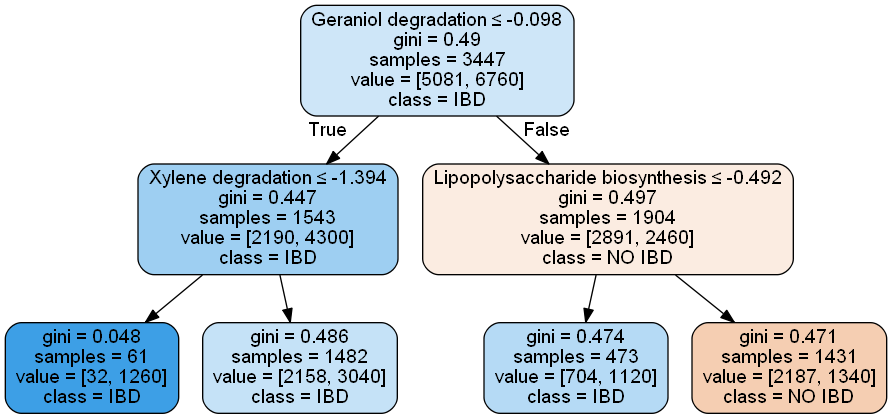

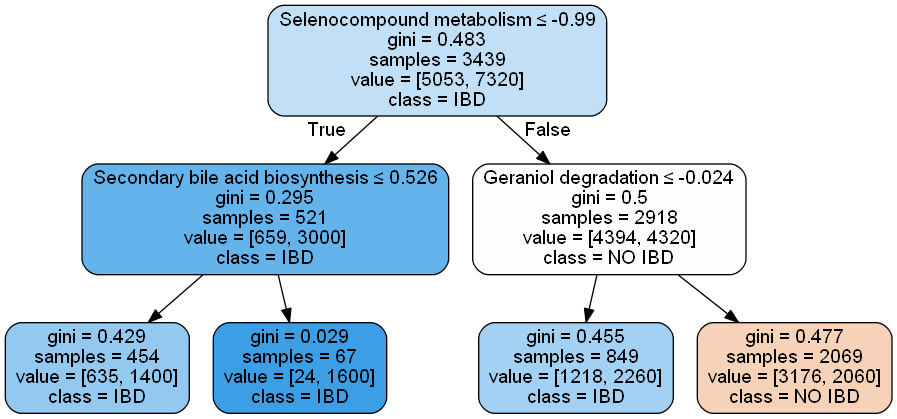

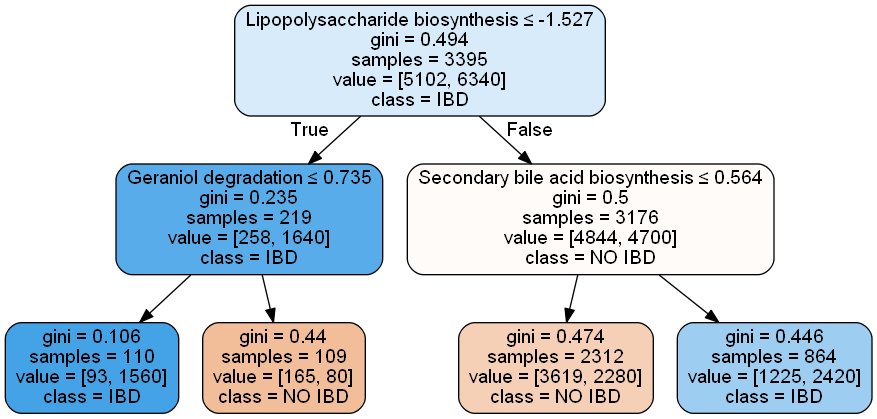

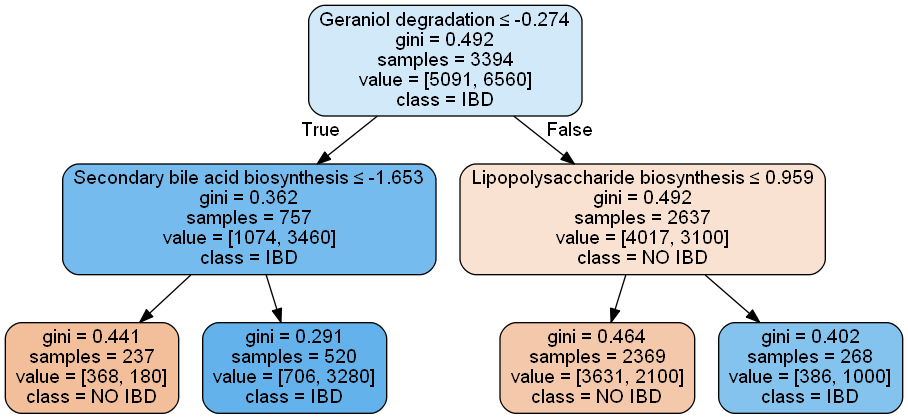

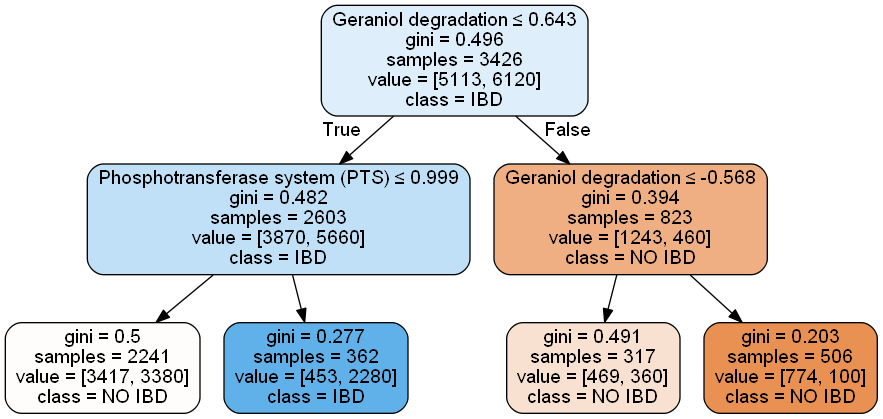

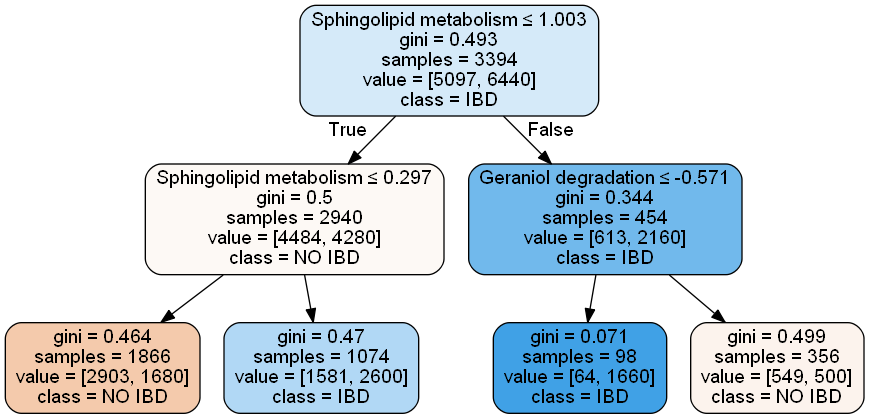

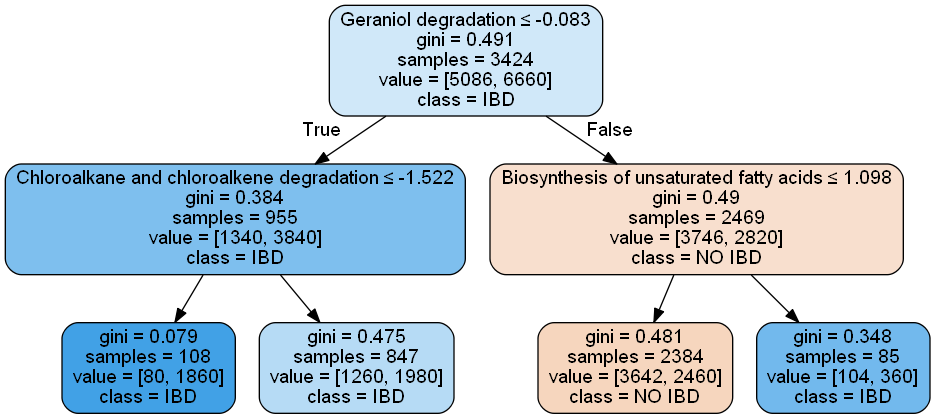

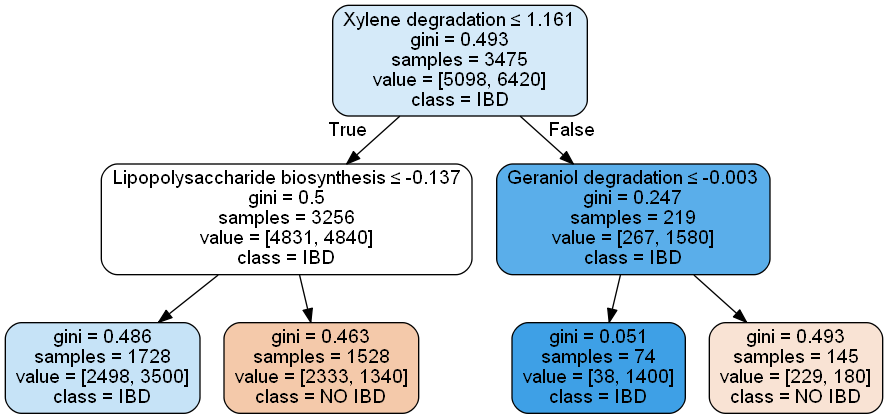

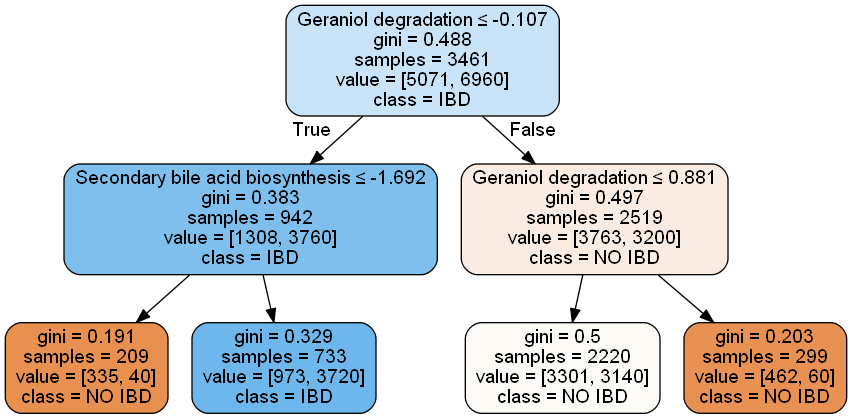

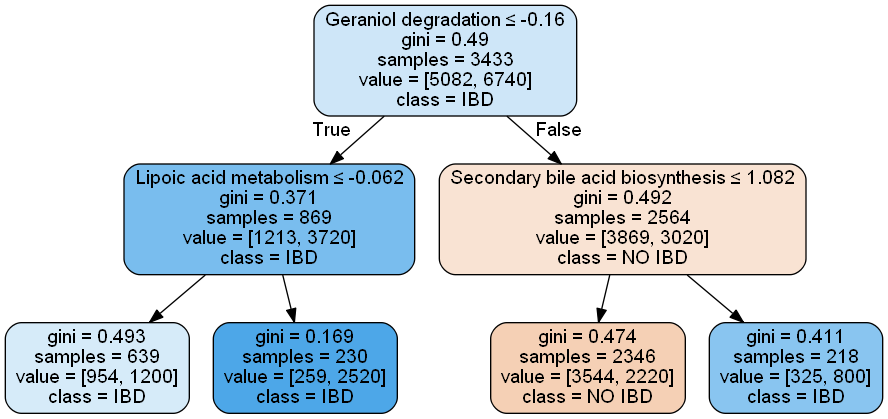

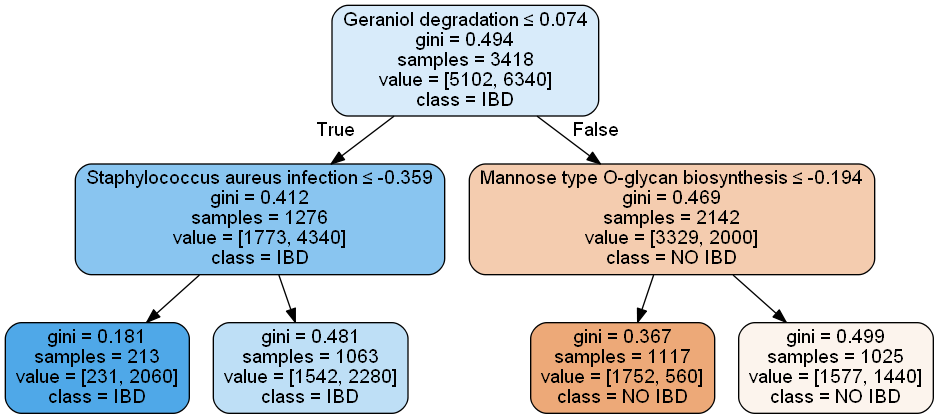

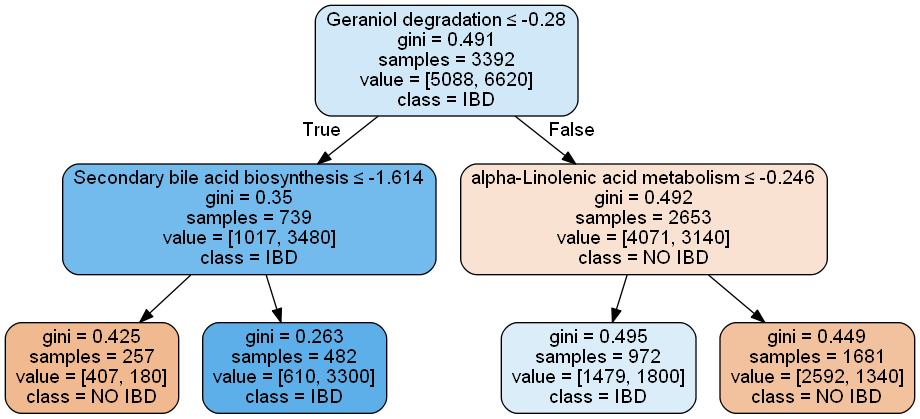

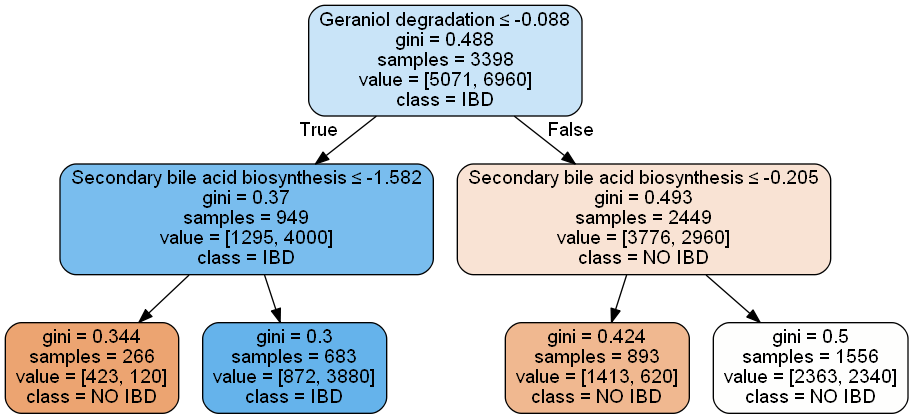

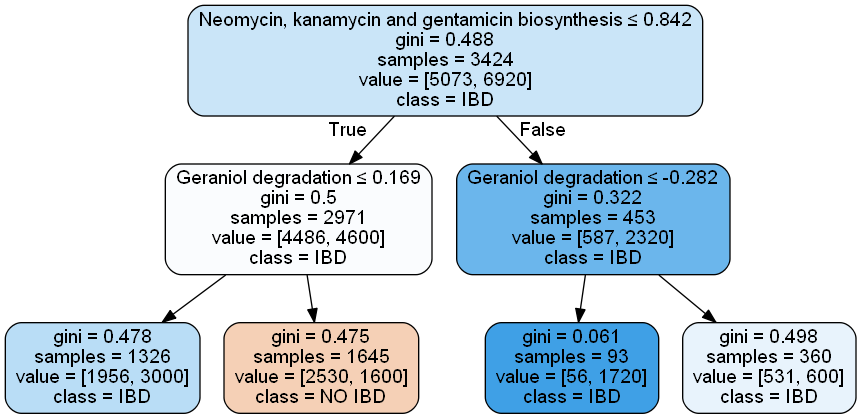

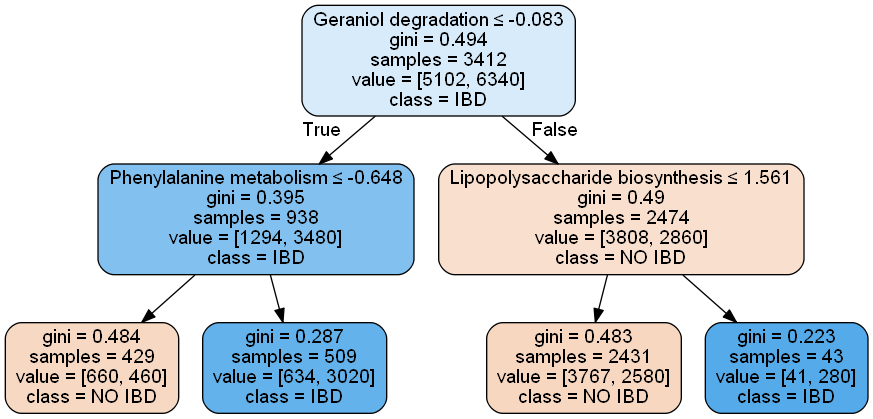

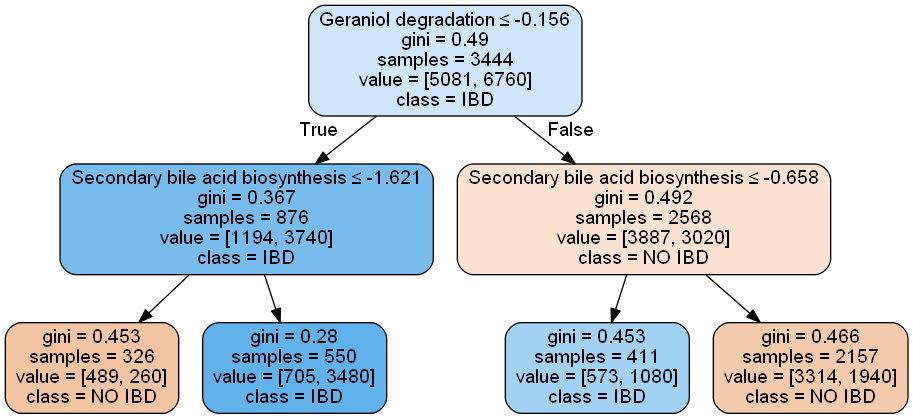

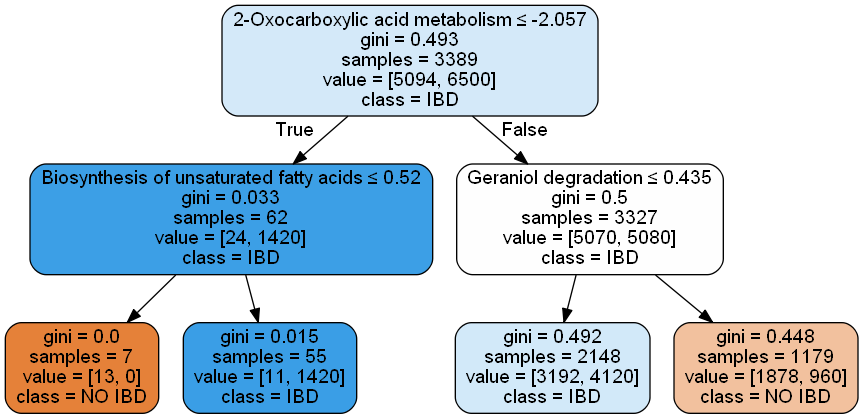

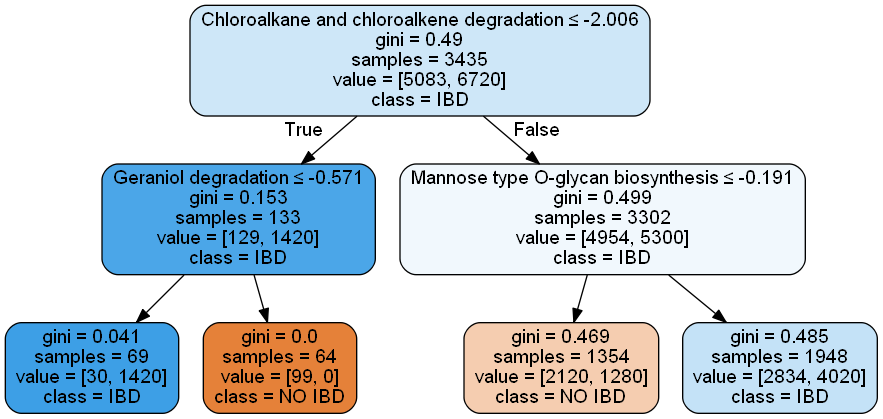

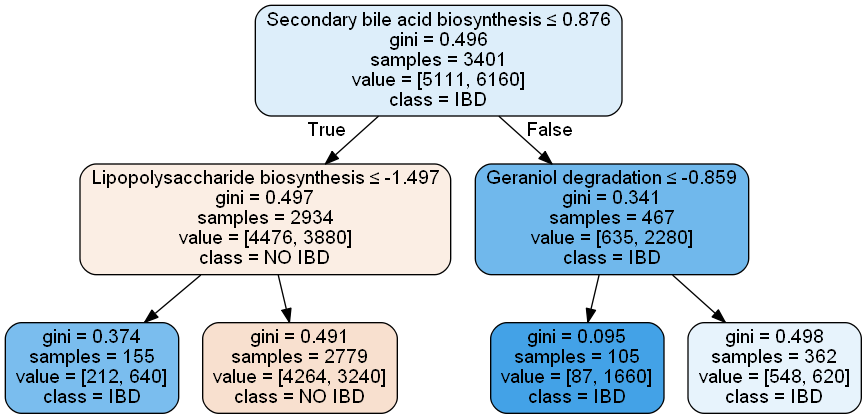

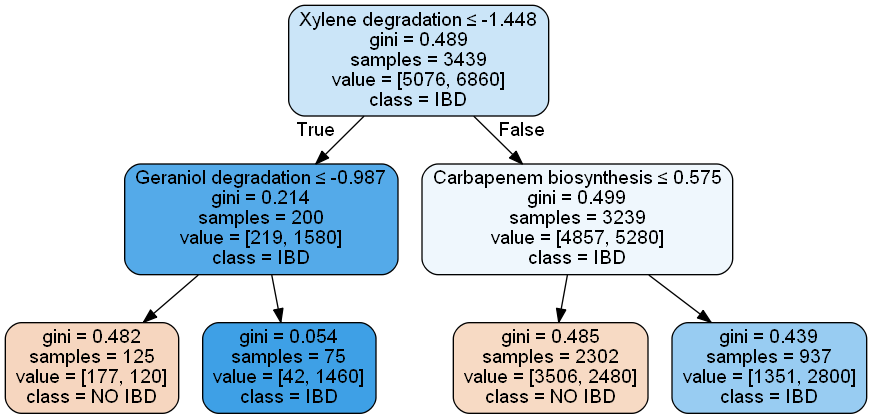

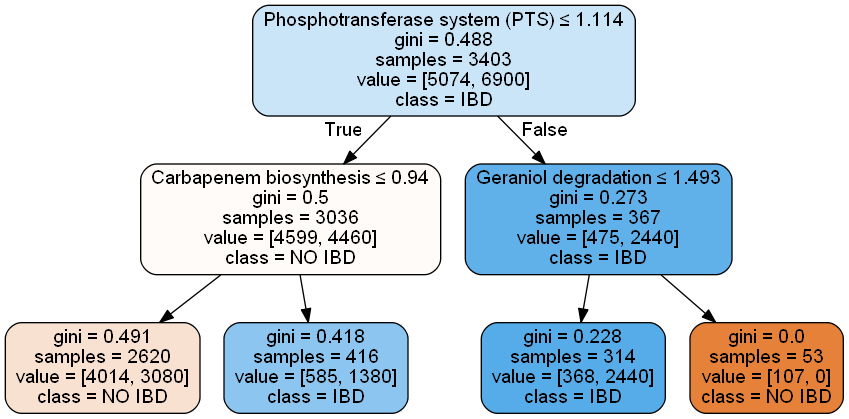

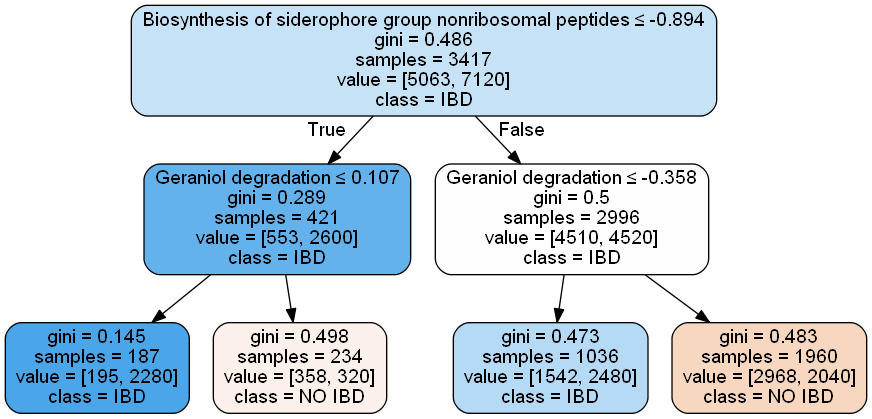

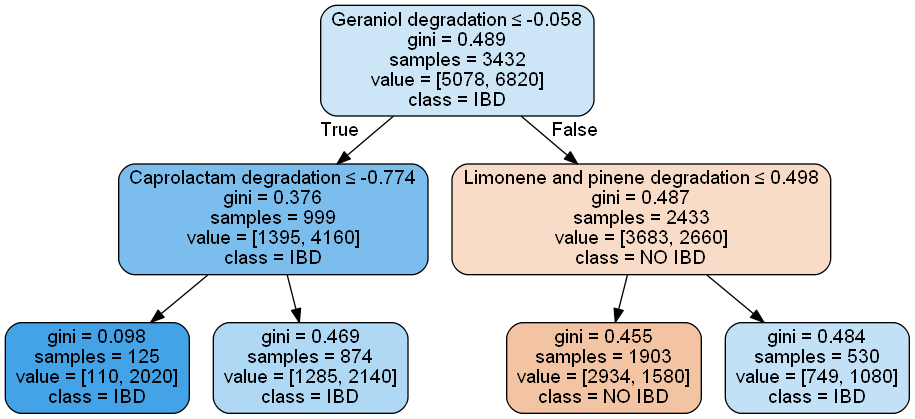

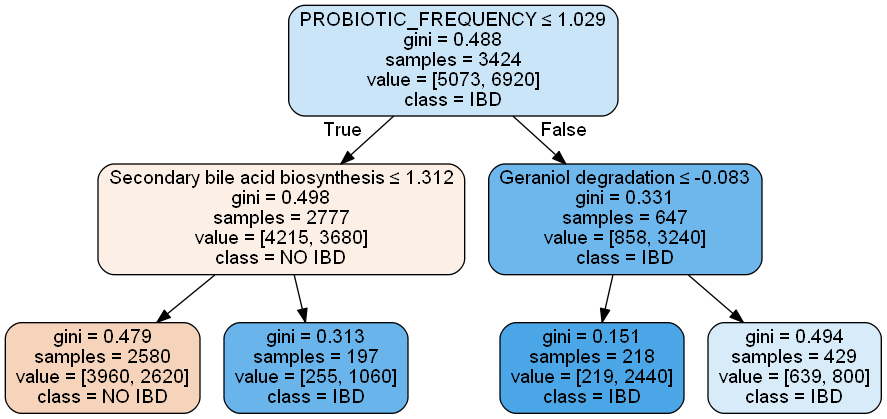

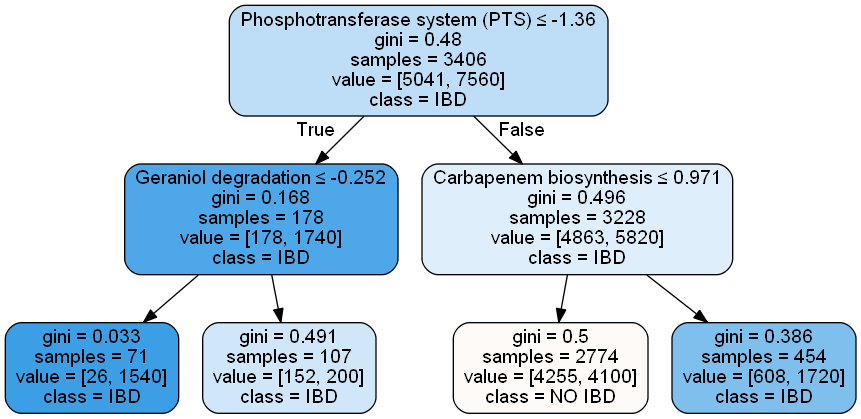

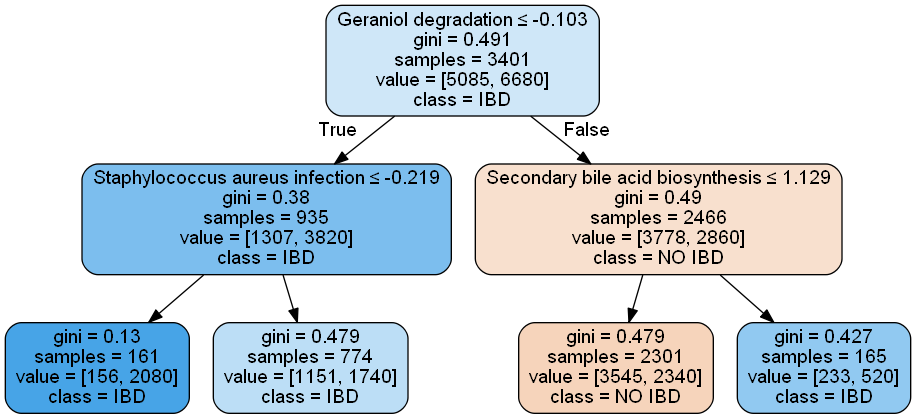

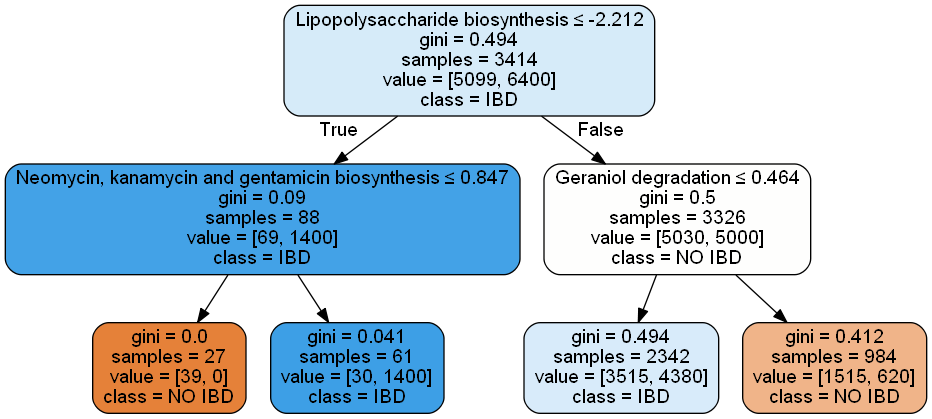

In [107]:
for i in range(95):
    est = m.estimators_[i]
    feat_inx = np.where(est.feature_importances_ > 0)
    tree_features = X_test.columns.values[feat_inx]
    if 'Geraniol degradation' in tree_features:
        display(makeDecisionTreeImage(est))

In [112]:
from treeinterpreter import treeinterpreter as ti

instances = X_test
prediction, bias, contributions = ti.predict(m, instances)

#Deduced that we want to look at the first column of the interpretations
prediction_use = prediction[:, 1]
bias_use = bias[:, 1]
contributions_use = contributions[:, :, 1]

In [130]:
inx = np.where(X_test.columns.values == "topic_86")
contributions_geraniol = np.squeeze(contributions_use[:, inx])
np.sum(contributions_geraniol > 0)


361

In [571]:
(len(y_train) - np.sum(y_train)) / np.sum(y_train) #Ratio of nonibd:ibd in training set - decided the weight

350.0
7434.0
7784


21.24

In [937]:
#We want the topics that have positive coefficients WHEN THE SAMPLE WAS ACTUALLY POSITIVE
ibd_samples = [i == 1 for i in y_test]
nonibd_samples = [i == 0 for i in y_test]
contributions_use[ibd_samples,0] #In some samples topics 0 contributed to a positive score, in some it contributed to a negative score. 

perc_pos_list = []
perc_neg_list = []
for topic in range(contributions_use.shape[1]): #for each topic
    perc_pos = np.sum(contributions_use[ibd_samples, topic] > 0) / np.sum(ibd_samples) #in the samples that were positive, how often did topic i get implicated as positive
    perc_pos_list.append(perc_pos)
    
    perc_neg = np.sum(contributions_use[nonibd_samples, topic]  < 0) / np.sum(nonibd_samples)
    perc_neg_list.append(perc_neg)
    
print(np.sum(np.array(perc_pos_list) > 0.8)) # 4 topics that positively contribute to IBD more than 70 % of the time
print(np.sum(np.array(perc_neg_list) > 0.90))
#Most of them are not positive all the time. So we need a way of figuring out when they are positive? What other variables are at play?
#The presence of other topics?
#Some phenotypic information?
perc_pos_list
perc_neg_list
consistent_pos_topics = np.array(perc_pos_list) > 0.7
consistent_neg_topics = np.array(perc_neg_list) > 0.9

4
19


In [949]:
keep_pos = np.array(perc_pos_list) > 0.8
consistent_pos_topics = X_test.columns.values[keep_pos]
consistent_pos_topics

keep_neg = np.array(perc_neg_list) > 0.95
consistent_neg_topics = X_test.columns.values[keep_neg]
consistent_neg_topics

array(['topic_47', 'topic_96', 'topic_154', 'topic_161', 'topic_204',
       'topic_235'], dtype=object)

In [954]:
qual_vecs_pos = qual_vecs.loc[:, consistent_pos_topics]
qual_vecs_neg = qual_vecs.loc[:, consistent_neg_topics]
qual_vecs_neg

topic_47  topic_96  topic_154  topic_161  topic_204  topic_235
0                                                                      
1000113 -0.245098 -0.227338  -0.463291  -0.240749  -0.123604   0.172471
1000269  0.074240  0.205478  -0.576746  -0.117811  -0.103398  -0.360665
1000512 -0.012795  0.229116  -0.241260   0.129507   0.311146   0.477588
1000986  0.172504  0.319715   0.216635   0.151802   0.037262   0.145176
1001007  0.136494 -0.167829  -0.060876   0.485520  -0.097311   0.189939
1001564 -0.139161 -0.637424  -0.312675   0.471665  -0.131335  -0.117935
1001908 -0.227846  0.191582  -0.272406   0.200011   0.376166   0.190244
1004326  0.176183 -0.384389   0.244001  -0.052698   0.448956  -0.050758
100457  -0.188600 -0.521293  -0.031449   0.644875   0.148534  -0.448105
1004910 -0.200761 -0.204924   0.260568   0.023295  -0.461071   0.172079
1005952 -0.357826  0.392634  -0.082839  -0.105577  -0.371941  -0.030035
1007430  0.211243 -0.317424   0.372482  -0.480436  -0.167623  -0.326257
1007750  0.518062  0.265846  -0.428687  -0.319427   0.014878  -0.396638
1007926  0.331390 -0.063323   0.274240  -0.052193  -0.095421   0.387406
1008348  0.140119  0.681484   0.421691  -0.119228  -0.489183  -0.185335
10085    0.361366  0.029322  -0.055443   0.159182   0.618047  -0.151286
1009362  0.103713 -0.001400  -0.281931   0.030590   0.000885  -0.310331
1010721 -0.029018  0.321987   0.025568   0.053512  -0.437447  -0.005949
1010876  0.281862 -0.131155   0.342417   0.243254   0.036627   0.156714
1011380  0.241116  0.203848   0.031087   0.021725   0.615562   0.351783
1011712  0.870760  0.309214  -0.079851   0.404265   0.169457  -0.183319
1012358 -0.039246  0.013169   0.338756  -0.357464  -0.249412   0.195145
101277   0.228969  0.242136  -0.530604  -0.004427   0.054949   0.072932
101293  -0.355859 -0.075139  -0.012681  -0.107154  -0.530934  -0.427831
1013285 -0.088697  0.451971   0.155295  -0.458971   0.129017  -0.219918
1013316  0.383446  0.161415   0.194686  -0.142490  -0.201603   0.097748
101542  -0.100446 -0.326930  -0.316153   0.220186   0.705135   0.163523
1015518 -0.312570  0.485570  -0.163795  -0.153277  -0.041843   0.422264
1015969  0.382842 -0.081236  -0.260141   0.037027  -0.111038  -0.468335
1016369  0.245745 -0.583353  -0.423457   0.209241   0.068862   0.053606
...           ...       ...        ...        ...        ...        ...
984924  -0.090509 -0.044810   0.360411  -0.499475   0.116521  -0.074056
98542    0.585388 -0.695875   0.229432   0.043499   0.360990  -0.368052
986708  -0.176493  0.040430   0.258074  -0.358366  -0.541963  -0.070931
9868    -0.082715 -0.345592  -0.435139  -0.072961  -0.218575  -0.159487
9870    -0.070754 -0.508773  -0.396711   0.194637  -0.257855  -0.062867
989234   0.454872  0.115267   0.038565   0.135593  -0.250399   0.005844
98939    0.314155 -0.344563  -0.044652   0.014945  -0.015061  -0.225233
989990  -0.236425  0.071607  -0.448345   0.296989  -0.190579   0.389154
992035   0.784121 -0.232972  -0.319541   0.137597  -0.432523  -0.038094
99242   -0.334882  0.331780   0.503224  -0.213244  -0.054839  -0.039376
99322    0.213904  0.209990   0.027902   0.379199   0.019451   0.584337
99331   -0.311453 -0.078693  -0.489027   0.543104  -0.040019   0.694308
993647   0.019262  0.233540  -0.147070  -0.179543  -0.253459  -0.022875
9939     0.001113 -0.169937  -0.176771   0.383944  -0.199289   0.095166
993934  -0.350285  0.191906   0.578296   0.018322   0.120676   0.237025
994257   0.514439 -0.202194   0.052592   0.243378  -0.038703   0.226585
994357   0.194793  0.233213  -0.033283  -0.190341   0.219377   0.155937
99531    0.290128 -0.378459  -0.027061  -0.055280  -0.057363   0.586503
99566    0.130274 -0.148620   0.112076  -0.558835  -0.235941  -0.075335
995900   0.033910 -0.126640   0.649870   0.059976  -0.218523   0.188848
996068   0.080348  0.046602  -0.203815   0.032315  -0.289828  -0.205123
996126   0.458612 -0.182471   0.493801   0.180377   0.254699   0.265626
996487  -0.038876 -0.105113   0.128463   0.139500

We can effectively get our dimensionality down to 10 while losing minimal accuracy in prediction power

Which taxa most contribute to those important topics?

In [5]:
#Arrange the rows so that the same taxa are together, then color the bars the color of the taxonomy
tax_table = pd.read_table("C:/Users/ctata/Documents/Lab/quality_vectors/data/greengenes/gg_13_8_otus/taxonomy/97_otu_taxonomy.txt",
                         index_col = 0, delimiter = ';|\t', header = None)
tax_table.index = tax_table.index.map(str)
keep = [i in qual_vecs.index.values for i in tax_table.index.values]
tax_table = tax_table.loc[keep, :]
tax_table = tax_table.reindex(sorted(tax_table.index.values))

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [618]:
print(getUnique(tax_table.iloc[:,5]))
[" g__Prevotella", " g__Desulfovibrio", " g__Bacteroides", " g__Butyricimonas", ' g__Lactobacillus', ' g__Clostridium',
' g__Turicibacter', ' g__Roseburia', ' g__Oscillospira', ' g__Sarcina', ' g__Ruminococcus', ' g__Dorea', ' g__Dialister', 
 ' g__Lachnospira', ' g__Enterobacter', ' g__Faecalibacterium', ' g__Akkermansia', ' g__Methylobacterium']

[' g__Methanobrevibacter', ' g__Parabacteroides', ' g__Prevotella', ' g__', ' g__Oxalobacter', ' g__Stenotrophomonas', ' g__Pantoea', ' g__Erwinia', ' g__Citrobacter', ' g__Aquamonas', ' g__Desulfovibrio', ' g__Pseudoclavibacter', ' g__Actinomyces', ' g__Actinobaculum', ' g__Mycobacterium', ' g__Corynebacterium', ' g__Mitsuokella', ' g__[Ruminococcus]', ' g__Peptoniphilus', ' g__Anaerococcus', ' g__Lactobacillus', ' g__Holdemania', ' g__Ruminococcus', ' g__Aerococcus', ' g__Dorea', ' g__Acidaminococcus', ' g__Clostridium', ' g__Bifidobacterium', ' g__Blautia', ' g__Tetragenococcus', ' g__Bacillus', ' g__Sneathia', ' g__Serratia', ' g__Leptotrichia', ' g__Anaerostipes', ' g__Paenibacillus', ' g__Sutterella', ' g__Lactococcus', ' g__Oscillospira', ' g__Bulleidia', ' g__Streptococcus', ' g__Dialister', ' g__Pseudomonas', ' g__Moryella', ' g__Solibacillus', ' g__Enterococcus', ' g__Achromobacter', ' g__Oligella', ' g__Actinobacillus', ' g__Comamonas', ' g__Brevibacterium', ' g__Dechloromon

(' g__Prevotella', ' g__Desulfovibrio', ' g__Bacteroides', ' g__Butyricimonas')

In [636]:
def plotHighMag(values):
    values[np.abs(values) < 0] = 0
    return(values)


In [626]:
def plotTopicTaxanomicMakeup(qual_vecs_obj, tax_table):
    #Sort taxa in qual_vecs by their family designation, for visualization purposes
    #Note the column order has not changed
    zipped = zip(qual_vecs_obj.index.values, tax_table.iloc[:, 5])
    sorted_zipped = sorted(zipped, key = lambda t: t[1], reverse = False)

    #Major players: 
    #major_players = [' f__Bacteroidaceae', ' f__Bifidobacteriaceae', ' f__Clostridiaceae', ' f__Desulfovibrionaceae',  ' f__Lachnospiraceae', 
    #' f__Turicibacteraceae', ' f__Vibrionaceae']
    major_players = [" g__Prevotella", " g__Desulfovibrio", " g__Bacteroides", " g__Butyricimonas", ' g__Lactobacillus', ' g__Clostridium',
' g__Turicibacter', ' g__Roseburia', ' g__Oscillospira', ' g__Sarcina']
    sorted_zipped = [i for i in sorted_zipped if i[1] in major_players]

    qual_vec_ids_ordered = [i[0] for i in sorted_zipped]
    taxa_name_ordered = [i[1] for i in sorted_zipped]
    qual_vecs_ordered = qual_vecs_obj.reindex(qual_vec_ids_ordered)
    
    from matplotlib import cm
    def getUniques(l):
        uniques = []
        for i in l:
            if i not in uniques:
                uniques.append(i)
        return(uniques)

    cmap = plt.cm.get_cmap("Set1")  # define the colormap
    # extract all colors from the .jet map
    unique_taxa = getUniques(taxa_name_ordered)
    numColors = len(unique_taxa)
    cmaplist = [cmap(i) for i in range(numColors)]
    color_dict = dict((key, value) for (key,value) in zip(unique_taxa, cmaplist))
    
    
    #Functional guild profiles
    plt.figure(figsize=(20,15))
    for i in range(qual_vecs_ordered.shape[1]):
        plt.subplot(4, 3, i+1)
        plt.bar(range(qual_vecs_ordered.shape[0]), qual_vecs_ordered.iloc[:,i], color = [color_dict[i] for i in taxa_name_ordered])

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
    plt.subplot(4, 3, qual_vecs_ordered.shape[1]+1)
    plt.legend(markers, color_dict.keys(), numpoints=1)

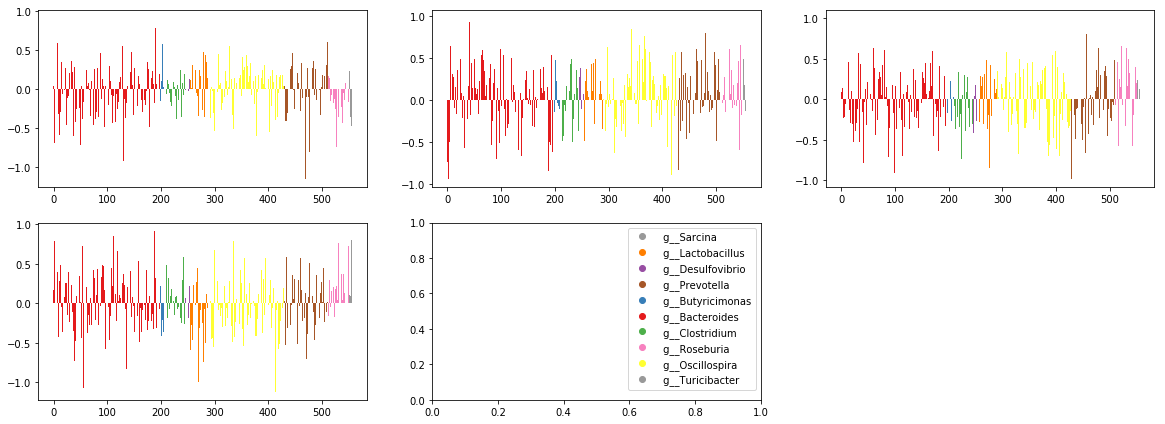

In [955]:
plotTopicTaxanomicMakeup(qual_vecs_pos, tax_table)

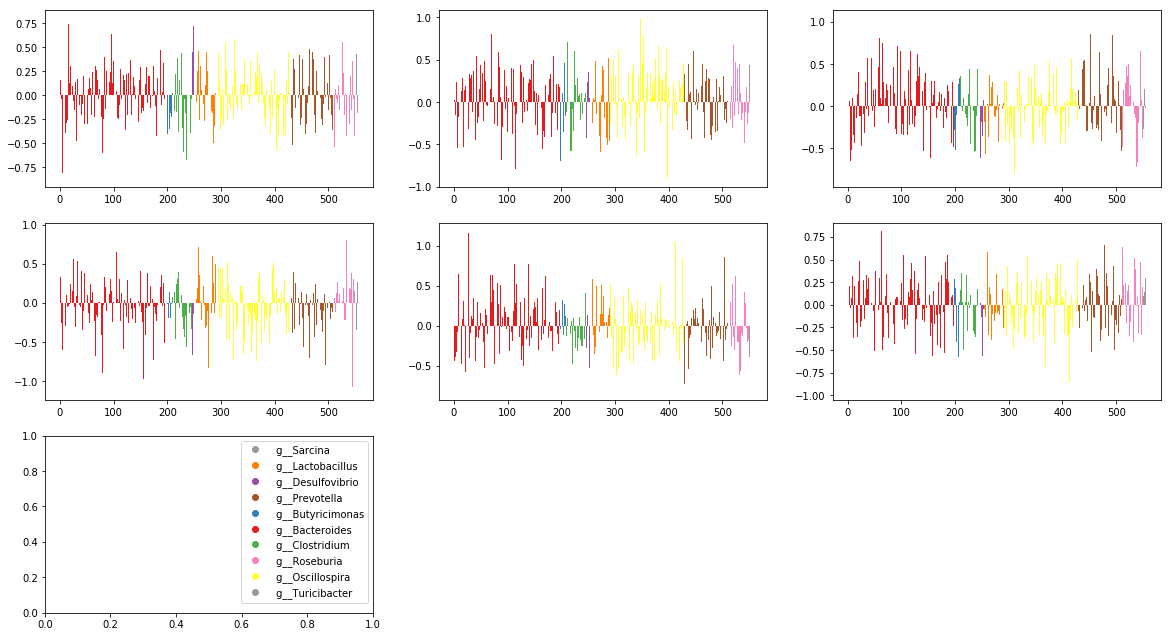

In [956]:
plotTopicTaxanomicMakeup(qual_vecs_neg, tax_table)

## INTERPRETATION - PERMANOVA AND CCA


In [6]:
#Group taxa by family, and see if there are any dimensions that are significantly different across family lines
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix as dm

#distance matrix
dot_product = qual_vecs.dot(qual_vecs.transpose())
mags = np.sqrt(np.square(qual_vecs).sum(axis=1))
tmp = dot_product.div(mags, axis = 0)
cosine_sim = tmp.div(mags, axis = 1)
cosine_dist = 1 - cosine_sim

In [9]:
cosine_dist = np.round(cosine_dist.values, decimals = 7)

In [25]:
otu_train.shape

(5419, 7731)

In [18]:
dist_mat = dm(cosine_dist)

In [19]:
grouping = tax_table.iloc[:, 3]
permutations = 100
perm = permanova(distance_matrix = dist_mat, grouping = grouping, permutations = permutations)

In [20]:
#Distance in embedding space can be explained (significantly) by phylogenetic classification (order)
#IE if you assigned order classification randomly, you would not see the separation in distances that you do see
perm

method name                PERMANOVA
test statistic name         pseudo-F
sample size                     7731
number of groups                 103
test statistic               9.11846
p-value                   0.00990099
number of permutations           100
Name: PERMANOVA results, dtype: object

#MINIMAL TAXONOMY PREDICTION - DELETE EVERYONE BUT THE MAIN PLAYERS FROM QUALITY VECTOR MATRIX, THEN EMBED AND PREDICT AGAIN

In [666]:
qual_vecs_obj = qual_vecs
zipped = zip(qual_vecs_obj.index.values, tax_table.iloc[:, 5])
sorted_zipped = sorted(zipped, key = lambda t: t[1], reverse = False)
major_players = [" g__Prevotella", " g__Desulfovibrio", " g__Bacteroides", " g__Butyricimonas", ' g__Lactobacillus', ' g__Clostridium',
' g__Turicibacter', ' g__Roseburia', ' g__Oscillospira', ' g__Sarcina', ' g__Ruminococcus', ' g__Dorea', ' g__Dialister', 
 ' g__Lachnospira', ' g__Enterobacter', ' g__Faecalibacterium', ' g__Akkermansia', ' g__Methylobacterium']
sorted_zipped = [i for i in sorted_zipped if i[1] in major_players]
sorted_zipped
keep = [i[0] for i in sorted_zipped]
qual_vecs_taxReduced = qual_vecs.loc[keep, ]



In [669]:
qual_vecs_taxReduced.shape

(844, 250)

0.7270389501605472


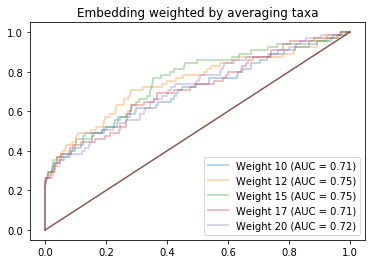

In [668]:
importlib.reload(hf)
#Set random seed
aucs
nf = 50

X_train = preprocessing.scale(embed_average(otu_train, qual_vecs_taxReduced))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs_taxReduced))

auc_list = hf.predictIBD(X_train, y_train, X_test, y_test, "Embedding weighted by averaging taxa")
print(np.mean(auc_list))
#We lose about ~5% accuracy by only including the "major players" in the gut
#Interesting thought: we could cycle through each taxonomic group, and see if any of them lose information much more than others

Go back and attribute importance to individual taxa by weighting by the importance in the rf: (feat_imp_sort) and the contributions of each taxa to that topic: (qual_vecs_pos)

In [478]:
topic_ids = [i[0] for i in feat_imp_sort]
imp_scores = [i[1] for i in feat_imp_sort]
qual_vecs_pos
keep = [topic_ids.index(i) for i in qual_vecs_pos.columns.values]
print(keep)
print(qual_vecs_pos.columns.values)
imp_scores_pos = np.array(imp_scores)[keep]

qual_vecs_pos_weighted = qual_vecs_pos.mul(imp_scores_pos, axis = 1) #These taxa are positively contributing to IBD, 
taxa_imp_scores = qual_vecs_pos_weighted.sum(axis = 1)
np.sum(taxa_imp_scores > 0) / len(taxa_imp_scores) #30% of the taxa are positively contributing to IBD, in the right context

[206, 51, 9, 177, 181, 239, 220, 8]
[188 155  26  48 231  63 183  86]


0.293701171875

USE THE EMBEDDINGS ON AUTISM DATA


### Can we improve prediction at all by using biofiltered features?

### Repeat the above tests predicting gluten intolerance

In [11]:
map_train, map_test, y_train, y_test = setTarget(map_train_save, map_test_save, target = "GLUTEN")

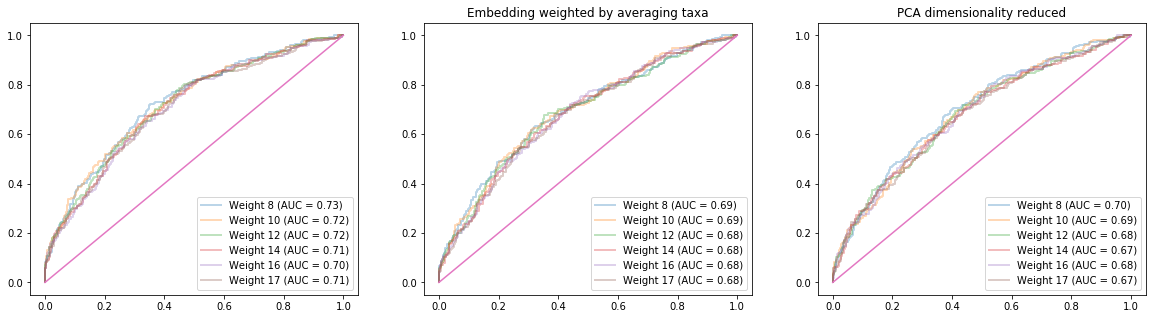

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)

#Normal
X_train = preprocessing.scale(hf.asinh(otu_train))
X_test = preprocessing.scale(hf.asinh(otu_test))
hf.predictIBD(X_train, y_train, X_test, y_test)

plt.subplot(1, 3, 2)
#Embed Average
X_train = preprocessing.scale(embed_average(otu_train, qual_vecs))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs))
hf.predictIBD(X_train, y_train, X_test, y_test, "Embedding weighted by averaging taxa")

plt.subplot(1, 3, 3)
#PCA
X_train, X_test = hf.getPCAReduced(X_train, X_test, components = 250)
hf.predictIBD(preprocessing.scale(X_train), y_train, preprocessing.scale(X_test), y_test, "PCA dimensionality reduced")

#### Problems: 
##### - Embeddings are very sensitive to sequencing depth (which dictates which taxa are "present" in any given environment)
##### - Challenge to interpret, even though they may be very meaningful
##### - Not sure how to integrate a dimension of time

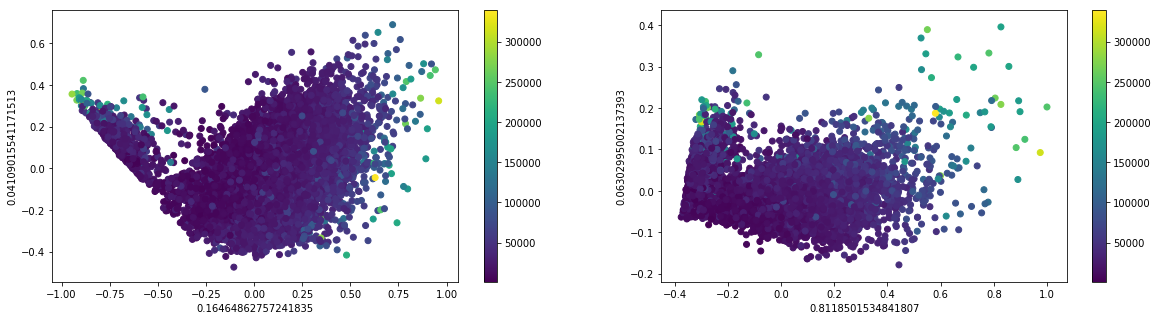

In [11]:
importlib.reload(hf)
plt.figure(figsize=(20,5))

otu_use = otu_train
sample_sums_table = otu_use.sum(axis = 1)
otu_use = otu_use.loc[sample_sums_table < 400000]

plt.subplot(1, 2, 1)
hf.plotPCA(hf.asinh(otu_use), otu_raw = otu_use, components = 250)
plt.subplot(1, 2, 2)
hf.plotPCA(embed_average(otu_use, qual_vecs), otu_raw = otu_use, components = 250)
